# Uncertainty Quantification 

### Team: 

##### 111742914 (Syed Fahad Sultan)
##### 111482304 (Anjul Kumar Tyagi)
##### 111753053 (Arjun Krishna)
##### 111447392 (Rohit Rao P)

# 1. Data Preparation

Reading the data 

In [2]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import math

data = pd.read_csv('data/poly_mo/quant_bootstraps.tsv', header=0, sep='\t')

truth = pd.read_csv('data/poly_mo/poly_truth.tsv', header=0, index_col=0, sep='\t')

quant = pd.read_csv('data/poly_mo/quant.sf', header=0, index_col=0, sep='\t')

Computing basic statistics for each transcript

In [3]:
data = data.apply(lambda x: np.sort(x.values))

lower_bounds = data.apply(lambda values: values[int(math.ceil(0.025*len(values)))])
upper_bounds = data.apply(lambda values: values[int(math.floor(0.975*len(values)))])

data_mins = data.min()
data_maxs = data.max()
data_means = data.mean()
data_std = data.std()

data = data.transpose()

data['lower_bound'] = lower_bounds
data['upper_bound'] = upper_bounds
data['min'] = data_mins
data['max'] = data_maxs
data['mean'] = data_means
data['std'] = data_std

Merging with ground truth

In [4]:
data['truth'] = truth

data = data[~data['truth'].isnull()]

Filtering out invalid transcripts

In [5]:
# data['invalid'] = data.apply(
#     lambda x: (x['truth'] < x['min']) or (x['max'] < x['truth']), axis=1)


# data['invalid'] = data.apply(
#     lambda x: ((x['mean']-(2*x['std'])) < x['truth'] ) and (x['truth'] < (x['mean']+(2*x['std']))), axis=1)


data['invalid'] = data.apply(
    lambda x: (x['truth'] < x['lower_bound']) or (x['upper_bound'] < x['truth']), axis=1)


Using mean error as a continuous variable for the quality of the predictions:

In [6]:
BOOTSTRAP_RUNS = 200

def get_mean_absolute_percentage_error(row):
    truth = row['truth']
    errors = [(truth-a_count)/truth for a_count in row[:BOOTSTRAP_RUNS]]
#     errors_percentage = np.mean(np.abs(errors))*100
    errors_percentage = np.mean((errors))*100
    return errors_percentage

data['mape'] = data.apply(get_mean_absolute_percentage_error, axis=1)

Computing normalized version of the mean error:

In [7]:
data['mae_n'] = data.apply(lambda x: (x['truth']-np.mean(x[:BOOTSTRAP_RUNS]))/(x['max']-x['min']+1) ,axis=1)

Merging with attributes available in quant.sf:

In [8]:
data['Length'] = quant['Length']
data['EffectiveLength'] = quant['EffectiveLength']
data['TPM'] = quant['TPM']
data['NumReads'] = quant['NumReads']

Reading equivalence class file:

In [9]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

Creating a dataframe for Equivalence classes:

In [67]:
unraveled = []

for i, eclass in enumerate(classes):
    for ts_idx in eclass[1:-1]:
        unraveled.append((i, int(eclass[0]), transcripts[int(ts_idx)], int(eclass[-1])))
        
eq_df = pd.DataFrame().from_dict(unraveled)
eq_df.columns=['eclass_id', 'eclass_size', 'transcript', 'numreads']

Merging equivalent classes dataframe with the other dataframe:

In [68]:
merged = pd.merge(eq_df, data[['invalid', 'min', 'max', 'std', 'truth', 'mape']].drop_duplicates(), left_on='transcript', right_index=True)

# 2. Observations

In [12]:
from math import log

from matplotlib import pyplot as plt, rc

plt.rcParams['figure.figsize'] = (15, 6) 
# fig.set_size_inches(15,10)

%matplotlib inline

In [177]:
print "Percentage of invalid rows: %s" % \
    (float(sum(data['invalid'])*100)/data.shape[0])

Percentage of invalid rows: 50.2547510134


### 1. Interestingly, valid transcripts tend to have smaller truth values

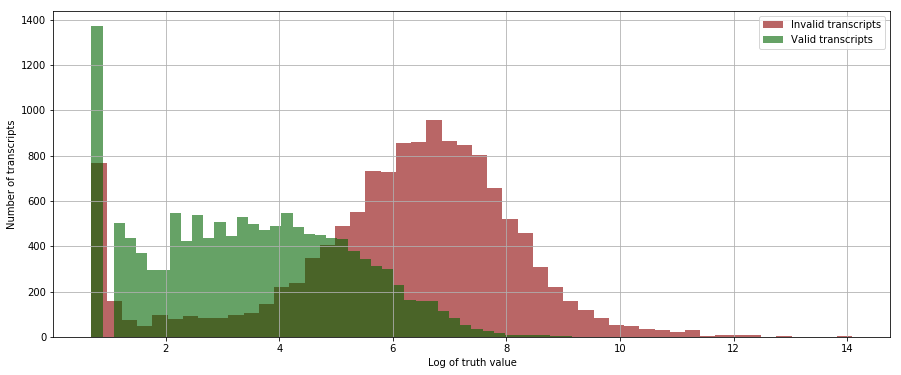

In [187]:
plt.rcParams['figure.figsize'] = (15, 6) 

data[data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkred')
data[~data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkgreen')
plt.xlabel('Log of truth value')
plt.ylabel('Number of transcripts')
plt.legend(['Invalid transcripts', 'Valid transcripts'])

### 2. Valid and Invalid transcripts show little variance w.r.t 'Length' and 'Effective Length' features

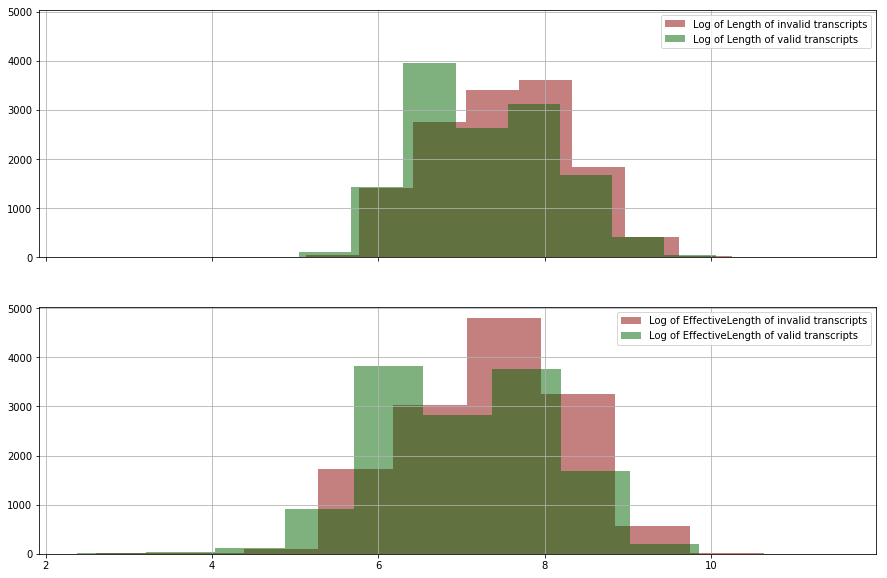

In [185]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])

### 3. Valid and Invalid transcripts do exhibit variance w.r.t 'TPM' and 'NumReads'

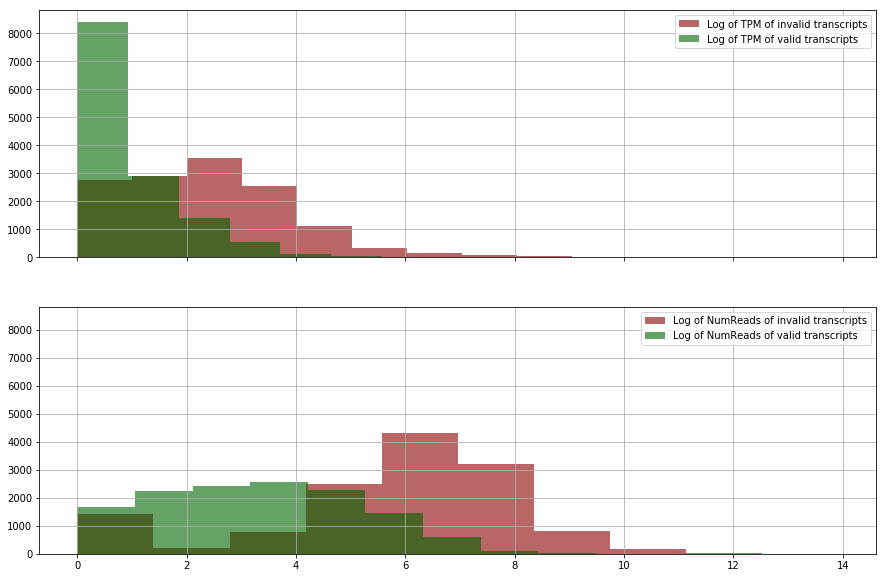

In [179]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['TPM', 'NumReads']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])

### Salmon generally underestimates the count, but when it overestimates, it really really overestimates!

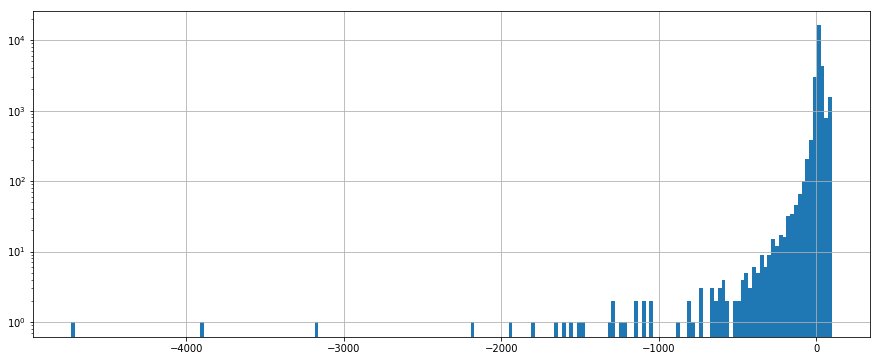

In [192]:
plt.rcParams['figure.figsize'] = (15, 6) 
fig.set_size_inches(15,10)

data['mape'].hist(log=True, bins=200)

In [16]:
(data['mape']>0).value_counts()

True     23920
False     2969
Name: mape, dtype: int64

### Mean Error as it relates to valid/invalid

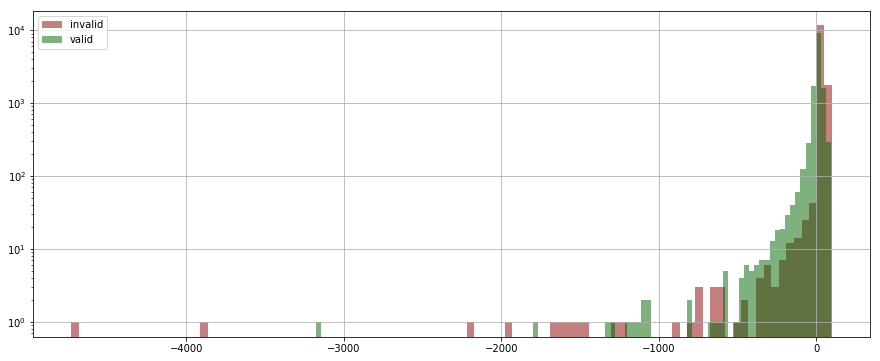

In [19]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkred')
data[~data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkgreen')
plt.legend(['invalid', 'valid'])

### Normalized mean error with respect to valid invalid transcripts

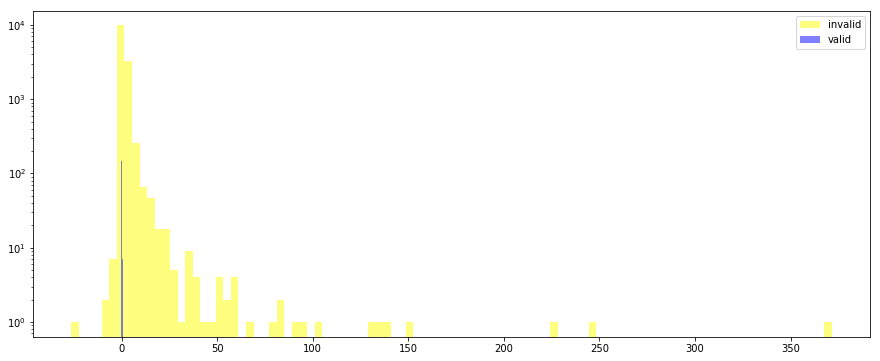

In [36]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='yellow')
data[~data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='blue')
plt.legend(['invalid', 'valid'])
plt.grid(False)

### Relationship between mean error normalized and attributes from quant.sf

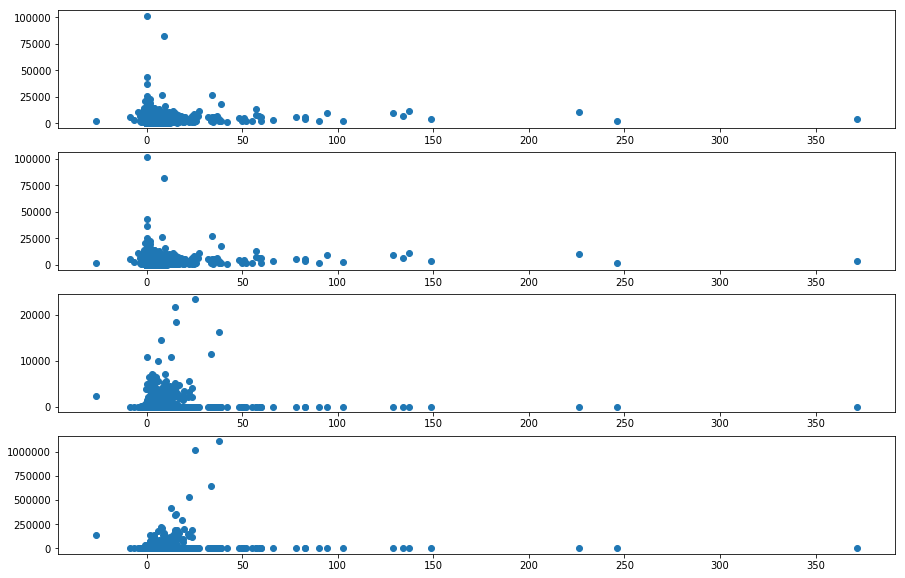

In [55]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

for i, prop in enumerate(properties):
#     ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkred')
#     ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkgreen')
#     axs[i].scatter(data['mae_n'].apply(lambda x: log(abs(x)) if abs(x)!=0 else log(0.001)), data[prop])
    axs[i].scatter(data['mae_n'], data[prop])
#     plt.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])



Zooming into the region with the .. density of points

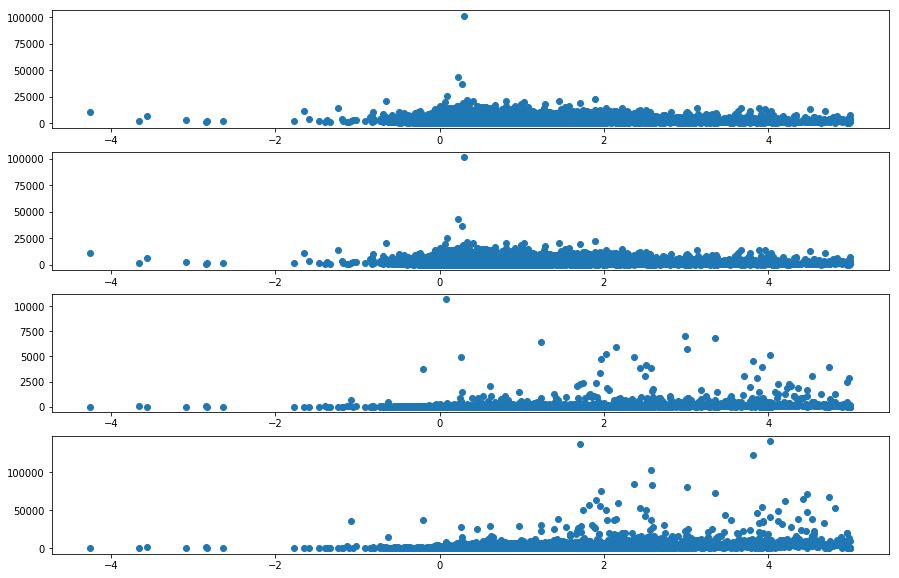

In [53]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

filtered = data[np.abs(data['mae_n']) < 5]

for i, prop in enumerate(properties):
#     ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkred')
#     ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkgreen')
#     axs[i].scatter(data['mae_n'].apply(lambda x: log(abs(x)) if abs(x)!=0 else log(0.001)), data[prop])
    axs[i].scatter(filtered['mae_n'], filtered[prop])
#     plt.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])



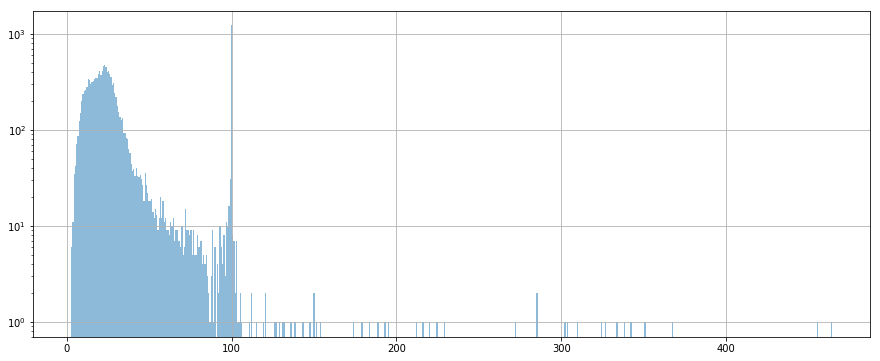

In [83]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
filtered = data[data.apply(lambda x: x['invalid'] and (np.abs(x['mape']) < 500), axis=1)]
filtered['mape'].hist(log=True, alpha=0.5, bins=600)
# plt.legend(['invalid', 'valid'])

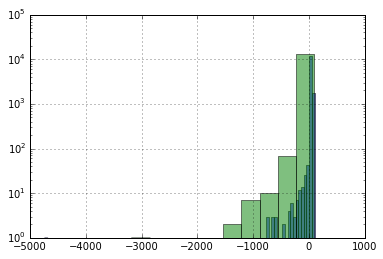

In [19]:
data[data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100)
data[~data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=10)

In [ ]:

    sum(data['mape'] < 5)
data['mape'].describe()sum(data['mape'] < 5)
data['mape'].describe()sum(data['mape'] < 5)
data['mape'].describe()


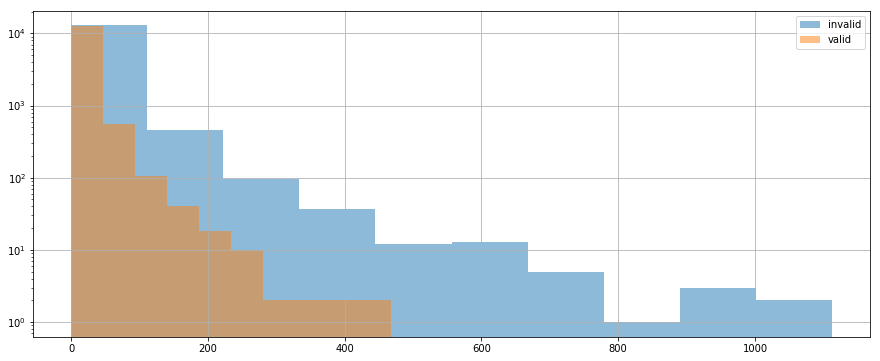

In [98]:
data[data['invalid']]['std'].hist(log=True, alpha=0.5)
data[~data['invalid']]['std'].hist(log=True, alpha=0.5)
plt.legend(['invalid', 'valid'])

In [57]:
sum(data['mape'] < 5)
data['mape'].describe()

count    26889.000000
mean        17.155695
std         70.396304
min      -4731.840136
25%          8.627180
50%         17.934069
75%         27.386641
max        100.000000
Name: mape, dtype: float64

### Most transcripts that have a small error are valid

In [94]:
data[np.abs(data['mape']) < 5]['invalid'].value_counts()

False    258
True      57
Name: invalid, dtype: int64

In [80]:
data['mape'].min()

-890.35660504348004

In [87]:
from scipy.stats import pearsonr

In [93]:
pearsonr(data['mape'], data['NumReads'])

(-0.044077154642581606, 4.9040522374147277e-13)

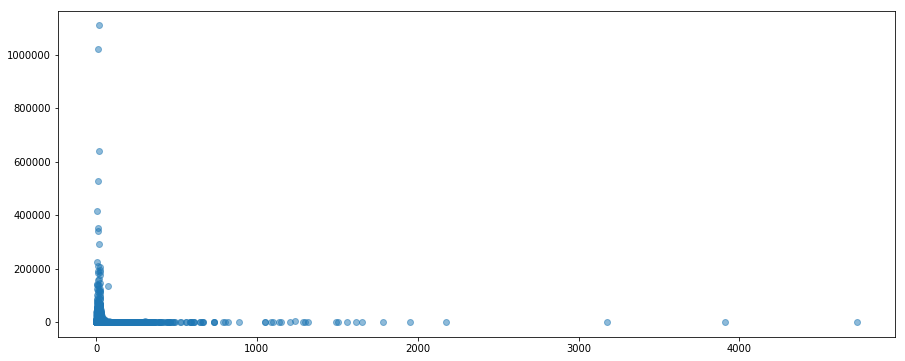

In [55]:
# fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
# fig.set_size_inches(15,10)

properties = ['TPM', 'NumReads']

# plt.scatter(mape_logged, data['NumReads'], alpha=0.5)

plt.scatter(data['mape'].apply(lambda x: np.abs(x)), data['NumReads'], alpha=0.5)

# for i, prop in enumerate(properties):
#     ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkred')
#     ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkgreen')
#     ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])

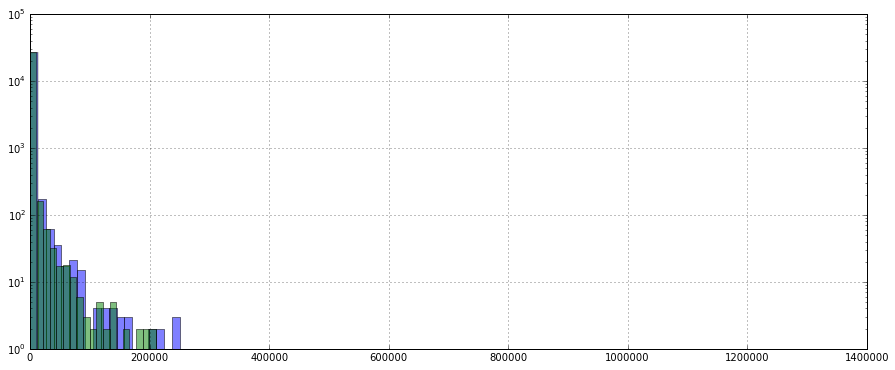

In [71]:
data['truth'].hist(log=True, alpha=0.5, bins=100)
data['mean'].hist(log=True, alpha=0.5, bins=100)

### 4. Valid and invalid transcripts are often found together in equivalent classes

#### 4.1. Approach 1

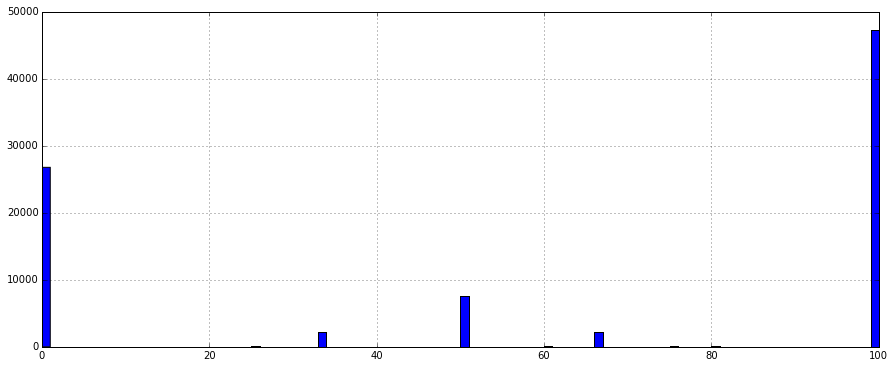

In [260]:
merged.groupby('eclass_id').apply(lambda x: (sum(x['invalid'])*100)/float(len(x))).hist(bins=100)

#### 4.1. Approach 2

Trying to look at the makeup of the equivalence classes in terms of percentage of valid and invalid transcripts:

In [72]:
percentages_invalid = []

for eclass in classes:
    invalid_count = 0
    for transcript_idx in eclass[1:-1]:
        if transcripts[int(transcript_idx)] in invalid_ts:
            invalid_count += 1
    percentage_invalid = (invalid_count*100)/float(eclass[0])
    percentages_invalid.append(percentage_invalid)
        

In [88]:
percentages_valid = [100-element for element in percentages_invalid]

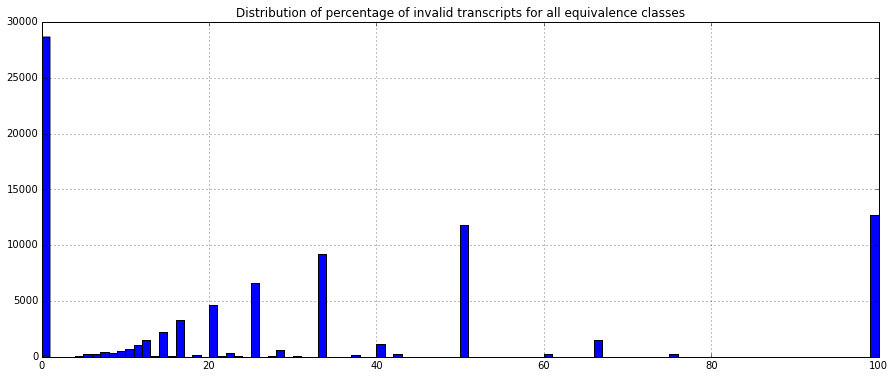

In [123]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.grid()
pd.Series(percentages_invalid).hist(bins=100)
plt.title('Distribution of percentage of invalid transcripts for all equivalence classes')

### 5. Number of classes valid and invalid transcripts belong to 

#### 5.1. Approach 1
Creating a new property for each transcript: the number of equivalence classes it belongs to.

In [149]:
all_ts = [int(transcript_idx) for eclass in classes for transcript_idx in eclass[1:-1]]
ts_eclass_counts = pd.DataFrame(pd.Series(all_ts).value_counts(), columns=['eclass_cnt'])

In [151]:
transcripts = pd.DataFrame(transcripts, columns=['transcript'])
merged = pd.merge(ts_eclass_counts, transcripts, left_index=True, right_index=True)

In [158]:
merged.index = merged['transcript']; del merged['transcript']

In [160]:
data['eclass_cnt'] = merged['eclass_cnt']

In [166]:
data['eclass_cnt'] = data['eclass_cnt'].fillna(0)

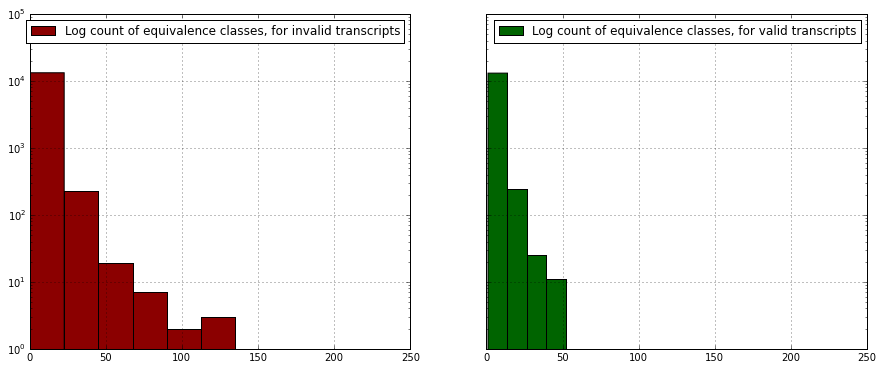

In [177]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
# fig.set_size_inches(15,15)

prop = 'eclass_cnt'

ax1 = data[data['invalid']][prop].hist(ax=axs[0], log=True, color='darkred')#.apply(lambda x: log(x+1))
ax1.legend(['Log count of equivalence classes, for invalid transcripts'])

ax = data[~data['invalid']][prop].hist(ax=axs[1], log=True, color='darkgreen')
ax.legend(['Log count of equivalence classes, for valid transcripts'])

#### 5.2. Approach 2

In [256]:
eq_df.head()

,eclass_id,eclass_size,transcript,overlap
0,0,1,ENST00000375898,385
1,1,4,ENST00000198767,47
2,1,4,ENST00000563559,47
3,1,4,ENST00000429751,47
4,1,4,ENST00000564131,47


In [ ]:
eq_df.groupby('transcript').apply(lambda x: )

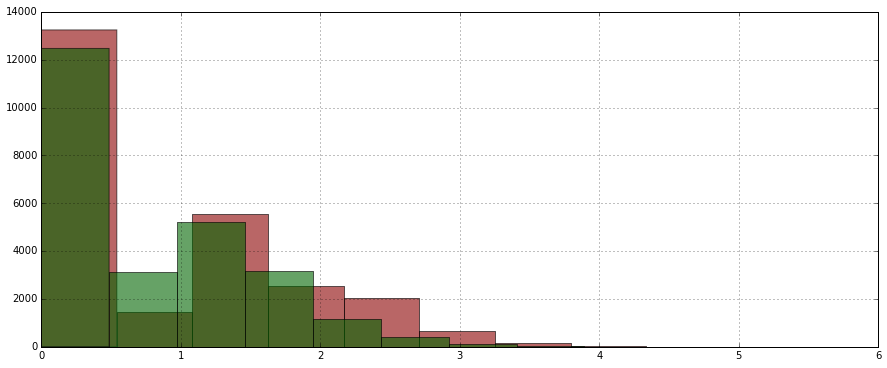

In [261]:
merged.groupby('transcript').apply(lambda x: x[x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkred')
merged.groupby('transcript').apply(lambda x: x[~x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkgreen')

### Sum of numreads weighted by size of equivalent classes it belongs to

In [82]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,mean,std,truth,invalid,mape,mae_n,Length,EffectiveLength,TPM,NumReads
ENST00000608495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,True,100.000000,1.000000,1672,1472.991,0.000000,0.000000
ENST00000382369,19.272902,21.122520,21.754805,22.437591,22.674037,23.822094,24.348252,24.387028,25.785329,26.017682,...,45.651584,12.636180,55.0,False,16.997120,0.145752,1420,1220.991,1.180968,46.855146
ENST00000360321,13.465284,15.456381,16.625515,17.269747,19.044385,19.792498,20.374741,20.605138,20.910507,21.264112,...,41.580917,11.378288,54.0,False,22.998302,0.203210,1575,1375.991,0.912080,40.780781
ENST00000400269,40.970483,45.874537,46.154529,46.272003,47.886339,48.150061,48.583841,50.326164,52.084900,53.358409,...,70.977499,10.912630,92.0,False,22.850545,0.330594,1022,822.991,2.705958,72.364073
ENST00000382352,1921.000000,1928.000000,1932.000000,1940.000000,1940.000000,1943.000000,1943.000000,1950.000000,1953.000000,1961.000000,...,2035.750000,45.244811,2653.0,True,23.266114,2.550620,3229,3029.991,20.638372,2032.000000


In [90]:
weightedreads = merged.groupby('transcript').apply(lambda x: sum(x['numreads'])).reset_index()
# plt.scatter(weightedreads, ['NumReads'])


In [93]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,mean,std,truth,invalid,mape,mae_n,Length,EffectiveLength,TPM,NumReads
ENST00000608495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,True,100.000000,1.000000,1672,1472.991,0.000000,0.000000
ENST00000382369,19.272902,21.122520,21.754805,22.437591,22.674037,23.822094,24.348252,24.387028,25.785329,26.017682,...,45.651584,12.636180,55.0,False,16.997120,0.145752,1420,1220.991,1.180968,46.855146
ENST00000360321,13.465284,15.456381,16.625515,17.269747,19.044385,19.792498,20.374741,20.605138,20.910507,21.264112,...,41.580917,11.378288,54.0,False,22.998302,0.203210,1575,1375.991,0.912080,40.780781
ENST00000400269,40.970483,45.874537,46.154529,46.272003,47.886339,48.150061,48.583841,50.326164,52.084900,53.358409,...,70.977499,10.912630,92.0,False,22.850545,0.330594,1022,822.991,2.705958,72.364073
ENST00000382352,1921.000000,1928.000000,1932.000000,1940.000000,1940.000000,1943.000000,1943.000000,1950.000000,1953.000000,1961.000000,...,2035.750000,45.244811,2653.0,True,23.266114,2.550620,3229,3029.991,20.638372,2032.000000


In [98]:
weightedreads.columns = ['transcript', 'wreads']

In [99]:
wr_merged = pd.merge(data, weightedreads, left_index=True, right_on=['transcript'])

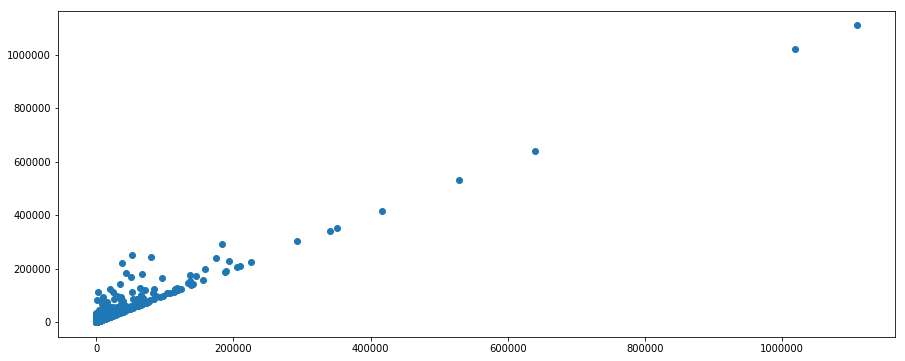

In [105]:
plt.scatter(wr_merged['NumReads'], wr_merged['wreads'])

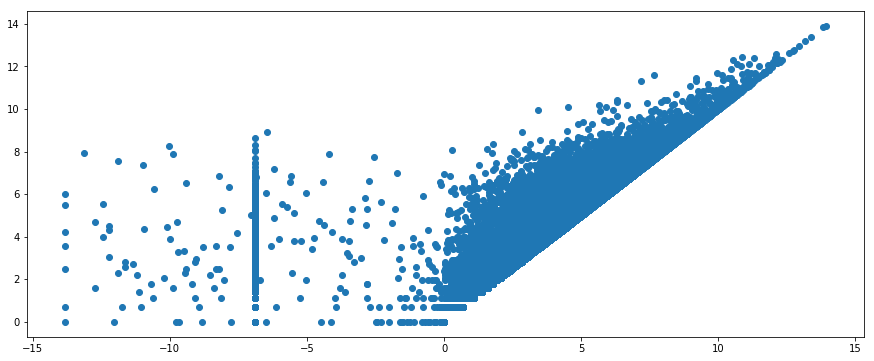

In [107]:
plt.scatter(wr_merged['NumReads'].apply(lambda x: log(x) if x!=0 else log(0.001)), wr_merged['wreads'].apply(lambda x: log(x) if x!=0 else log(0.001)))

In [184]:
invalid = merged[merged['invalid']]
valid = merged[~merged['invalid']]

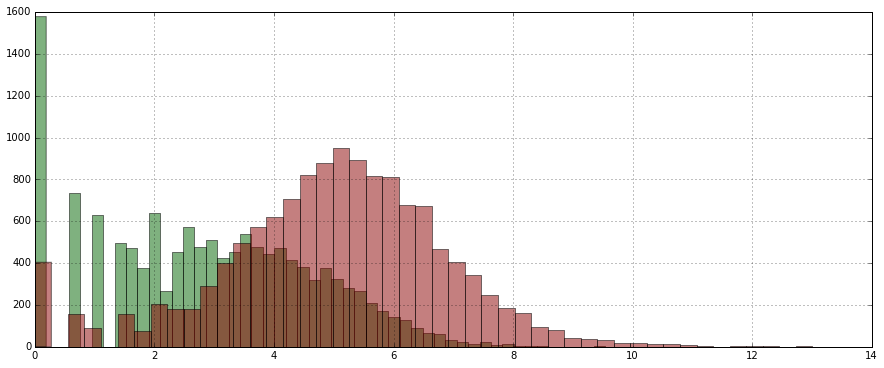

In [185]:
valid.groupby('transcript').apply(lambda x: sum(x['overlap'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkgreen')
invalid.groupby('transcript').apply(lambda x: sum(x['overlap'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkred')

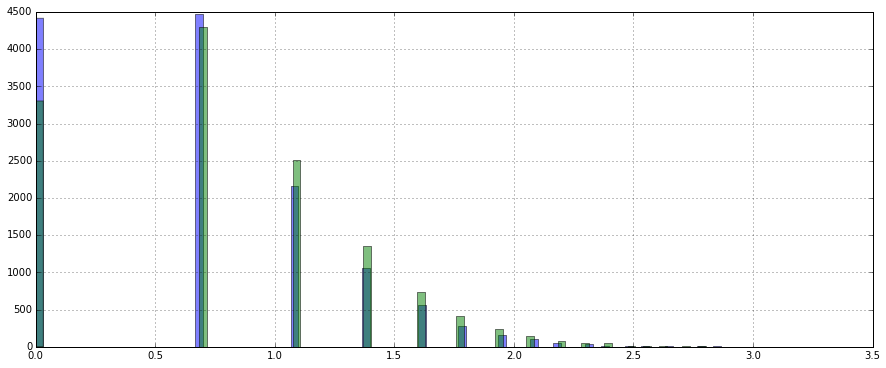

In [158]:
valid.groupby('transcript').apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log).hist(alpha=0.5, bins=100)
invalid.groupby('transcript').apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log).hist(alpha=0.5, bins=100)

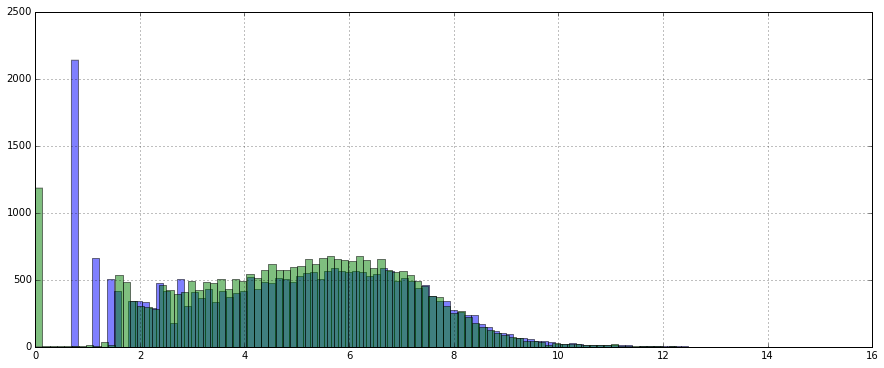

In [172]:
data['truth'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)
data['max'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)

In [ ]:
eq_df_uniques = eq_df[['eclass_id', 'eclass_len', 'overlap']].drop_duplicates()

from math import log 

plt.rcParams['figure.figsize'] = (15, 6)
plt.scatter(eq_df_uniques['eclass_len'], eq_df_uniques['overlap'].apply(lambda x: log(x+1)), alpha=1, s=30)
plt.grid()
plt.xlabel('Length of equivalent classes')
plt.ylabel('Overlap of equivalent classes')
plt.title("Relationship between length and overlap of equivalent classes")
plt.show()

In [ ]:
eq_df[eq_df['eclass_len'] == 1]['overlap'].apply(log).hist()

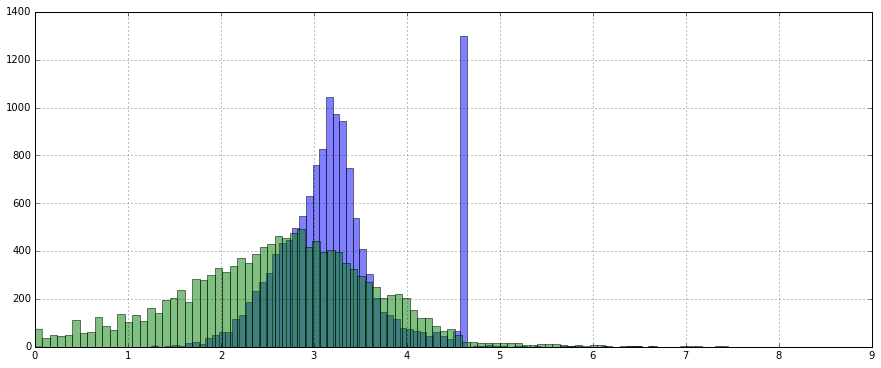

In [157]:
data[data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)
data[~data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)

In [55]:
data[['invalid', 'truth', 'quality', 'quality2']]

,erroneous,truth,quality,quality2
ENST00000608495,True,1,20000.000000,100.000000
ENST00000382369,False,55,4732.443537,16.997120
ENST00000360321,False,54,5150.160300,22.998302
ENST00000400269,False,92,4639.511821,22.850545
ENST00000382352,True,2653,4653.222767,23.266114
ENST00000342665,True,2804,5757.382311,28.786912
ENST00000609179,True,261,5947.126437,29.735632
ENST00000217233,True,382,5935.956118,29.679781
ENST00000449710,True,350,6630.657128,33.153286
ENST00000422053,True,259,4691.683835,23.435034


In [58]:
"Minimum/Maximum error: %s/%s" % (data['mape'].min(), data['mape'].max())

'Minimum/Maximum error: -4731.84013587/100.0'

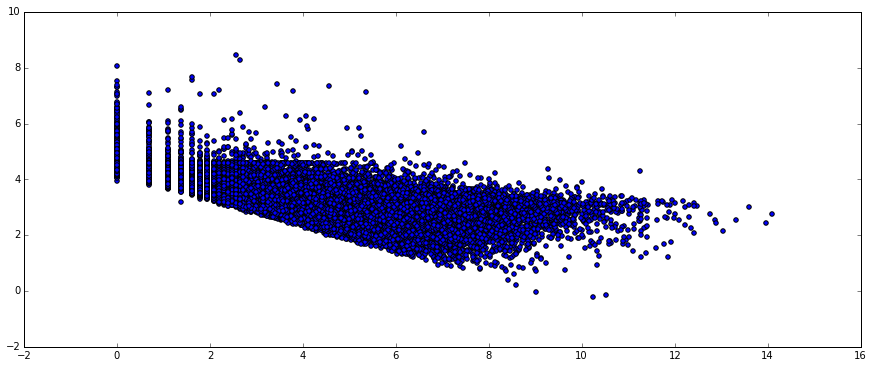

In [67]:
plt.scatter(data['truth'].apply(log), data['mape'].apply(log))

In [60]:
plt.scatter?

In [65]:
eq_classes_count = eq_df.groupby('transcript').apply(lambda x: x['eclass_id'].unique().shape[0])

In [66]:
eq_classes_count

transcript
ENST00000000233     2
ENST00000000412     3
ENST00000000442     8
ENST00000001008     2
ENST00000002125     9
ENST00000002165     3
ENST00000002501     3
ENST00000002596     2
ENST00000003084     1
ENST00000003100     2
ENST00000003302    14
ENST00000003583     2
ENST00000003912     1
ENST00000004103     5
ENST00000004980     9
ENST00000004982     2
ENST00000005082    12
ENST00000005178     1
ENST00000005257     2
ENST00000005259     1
ENST00000005260     2
ENST00000005284     1
ENST00000005286     9
ENST00000005340     4
ENST00000005374     5
ENST00000005386     4
ENST00000005558     1
ENST00000006053     4
ENST00000006251     7
ENST00000006275     5
                   ..
ENST00000610127     2
ENST00000610128     1
ENST00000610130     1
ENST00000610139     2
ENST00000610140     6
ENST00000610144     8
ENST00000610153     5
ENST00000610154     3
ENST00000610158     1
ENST00000610162     1
ENST00000610171     1
ENST00000610177     1
ENST00000610179     3
ENST00000610180    41

## Classification

In [60]:
data[data.columns[200:]].head()

,lower_bound,upper_bound,min,max,mean,std,truth,invalid,mape,mae_n,Length,EffectiveLength,TPM,NumReads
ENST00000608495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,True,100.000000,1.000000,1672,1472.991,0.000000,0.000000
ENST00000382369,23.822094,72.156339,19.272902,82.412001,45.651584,12.636180,55.0,False,16.997120,0.145752,1420,1220.991,1.180968,46.855146
ENST00000360321,19.792498,65.783722,13.465284,73.579817,41.580917,11.378288,54.0,False,22.998302,0.203210,1575,1375.991,0.912080,40.780781
ENST00000400269,48.150061,92.132202,40.970483,103.560523,70.977499,10.912630,92.0,False,22.850545,0.330594,1022,822.991,2.705958,72.364073
ENST00000382352,1943.000000,2116.000000,1921.000000,2162.000000,2035.750000,45.244811,2653.0,True,23.266114,2.550620,3229,3029.991,20.638372,2032.000000


In [ ]:
from sklearn.linear_model import LinearRegression

features = ['min', 'max', 'std', 'mean', 'Length', 'EffectiveLength', 'TPM', 'NumReads']
ys = [data['truth'], data['invalid'], data['mape'], data['mae_n']]
reg = LinearRegression()
reg.fit(data)